# Processing raw data
This section combines the raw data, the adjustments and cleaned bars to get processed 1-minute data. After processing we also detect the halts to create a <code>halted</code> flag. There are no gaps for processed data. All stocks that are active on a certain day have minute bars for every minute, from pre to post market, even if no trades took place. Empty bars are forward filled. Only for the first day, backwards filling may be done.

The steps:
1. The bars are cleaned first, because the cleaned data is derived from raw tick data.
2. Then the cleaned bars are split and dividend adjusted. (Split adjustment is done first for bars and dividends, then the split-adjusted bars are dividend-adjusted using the split-adjusted dividends.)
3. After this, the data is forward filled. If there are still NA values, the data is backward filled. Forward/backward filled bars are flagged by setting <code>tradeable</code> to False.
4. Lastly, halts are detected to create the <code>halted</code> flag.
5. The true start/end dates are determined for each stock.

To make the loop more readable, we will first build the functions <code>split_adjust</code>, <code>dividend_adjust</code> and <code>detect_halts</code>.

In [30]:
from utils import get_tickers, get_market_hours
from datetime import datetime, date, time
import mplfinance as mpf
import pandas as pd
import numpy as np
import os
DATA_PATH = "../../../data/polygon/"

## Split adjustment example for BBD

In [31]:
adjustments = pd.read_csv(DATA_PATH + f"raw/adjustments/BBD.csv", parse_dates=True, index_col=0)
bars = pd.read_parquet(f"{DATA_PATH}raw/m1/BBD-2019-01-01.parquet")

adjustments.index = pd.to_datetime(adjustments.index).date
splits = adjustments[adjustments.type == "SPLIT"].copy()

In [32]:
splits

,type,subtype,amount
2019-04-01,SPLIT,N,0.833333
2020-04-14,SPLIT,N,0.909091
2021-04-19,SPLIT,N,0.909091
2022-04-19,SPLIT,N,0.909091


In [33]:
trading_dates_ticker = np.unique(bars.index.date)

# The original dates of 'split' are the dates of the split. But adjustments are for all dates before the split.
splits['cumulative_adjustment'] = splits['amount'][::-1].cumprod()
splits = splits.drop(columns=['type', 'subtype', 'amount'])
splits

,cumulative_adjustment
2019-04-01,0.626096
2020-04-14,0.751315
2021-04-19,0.826446
2022-04-19,0.909091


In [34]:
splits.index = splits.index.to_series().apply(lambda date_ : max(d for d in trading_dates_ticker if d < date_)) # Shift dates 1 day back (the reason we cannot just use timedelta(days=1) is because that might not be a trading date.
splits = splits.reindex(trading_dates_ticker) # Reindex using stock data 
splits.cumulative_adjustment = splits.cumulative_adjustment.fillna(method='bfill').fillna(value=1) # Backward fill and fill ones

In [35]:
splits[splits.index > date(2019, 3, 26)][:5]

,cumulative_adjustment
2019-03-27,0.626096
2019-03-28,0.626096
2019-03-29,0.626096
2019-04-01,0.751315
2019-04-02,0.751315


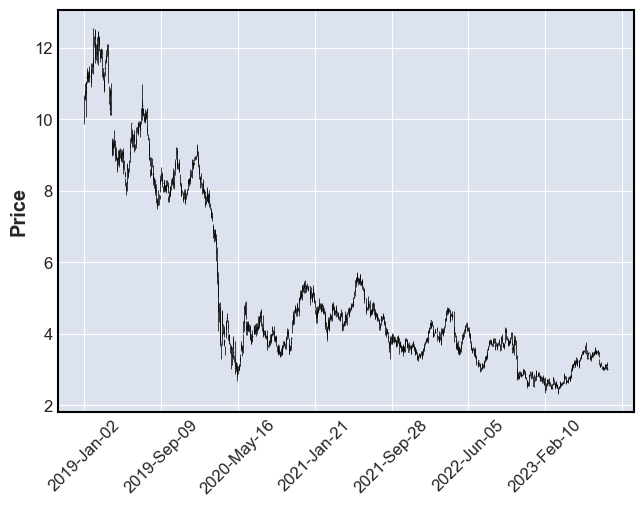

In [36]:
daily = bars.resample('1D').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
mpf.plot(daily, type='ohlc', show_nontrading=False, warn_too_much_data=1000000)

In [37]:
bars['date'] = bars.index.date
bars = bars.merge(splits, left_on='date', right_index=True, how='left')
bars[['open', 'high', 'low', 'close']] = bars[['open', 'high', 'low', 'close']].multiply(bars["cumulative_adjustment"], axis="index")
bars['volume'] = bars['volume'].divide(bars["cumulative_adjustment"], axis="index")

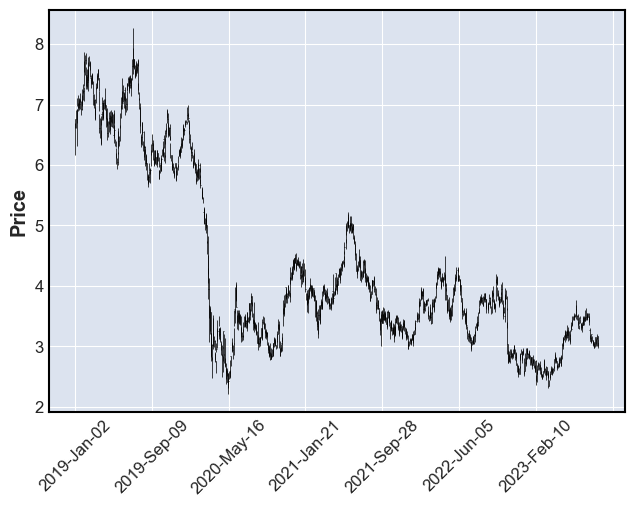

In [38]:
daily = bars.resample('1D').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
mpf.plot(daily, type='ohlc', show_nontrading=False, warn_too_much_data=1000000)

We also have to split-adjust the dividends, if there are splits.

In [41]:
dividends = adjustments[adjustments.type == "DIV"].copy()
dividends.head(3)

,type,subtype,amount
2019-01-03,DIV,CD,0.003197
2019-02-04,DIV,CD,0.003156
2019-03-06,DIV,CD,0.003179


In [42]:
dividends['cum_div_date'] = dividends.index.to_series().apply(lambda date_ : max(d for d in trading_dates_ticker if d < date_)) # Shift dates 1 day back. We want the cum-dividend date, not ex-dividend.
dividends.index.names = ['ex_div_date']
dividends = dividends[['cum_div_date', 'amount']]
dividends = dividends.merge(splits, left_on='cum_div_date', right_index=True, how='left')
dividends['amount'] = dividends['amount'].multiply(dividends["cumulative_adjustment"], axis="index")
dividends.drop(columns=['cumulative_adjustment'], inplace=True)

In [43]:
dividends.head(3)

,cum_div_date,amount
ex_div_date,,
2019-01-03,2019-01-02,0.002002
2019-02-04,2019-02-01,0.001976
2019-03-06,2019-03-05,0.001990


Putting it all together in a function yields:

In [44]:
def split_adjust(bars, ticker):
    """
    Returns the split-adjusted bars AND dividends.
    If there is no split-data, the original bars are returned.
    If there is no dividend-data, None is returned. Else we return the split-adjusted dividends with a new column "cum_div_date".
    """

    if os.path.isfile(DATA_PATH + f"raw/adjustments/{ticker}.csv"):
        adjustments = pd.read_csv(DATA_PATH + f"raw/adjustments/{ticker}.csv", parse_dates=True, index_col=0)

        adjustments.index = pd.to_datetime(adjustments.index).date


        trading_dates_ticker = np.unique(bars.index.date)
        # TO DO: make sure no dates in adjustments fall outside trading_dates_ticker
        adjustments = adjustments[(adjustments.index > trading_dates_ticker[0]) & (adjustments.index <= trading_dates_ticker[-1])]

        splits = adjustments[adjustments.type == "SPLIT"].copy()
        dividends = adjustments[adjustments.type == "DIV"].copy()

        # Adjust for splits
        if not splits.empty:
            splits['cumulative_adjustment'] = splits['amount'][::-1].cumprod()
            splits = splits.drop(columns=['type', 'subtype', 'amount'])

            
            # In rare cases, the dividend data exists outside of the price data. This leads to a ValueError because the max() function receives nothing. Then we just need to skip.
            try:
                # The original dates of 'split' are the dates of the split. But adjustments are for all dates before the split.
                splits.index = splits.index.to_series().apply(lambda date_ : max(d for d in trading_dates_ticker if d < date_)) # Shift dates 1 day back (the reason we cannot just use timedelta(days=1) is because that might not be a trading date.
            except ValueError:
                return bars, None
            
            splits = splits.reindex(trading_dates_ticker) # Reindex using stock data 
            splits.cumulative_adjustment = splits.cumulative_adjustment.fillna(method='bfill').fillna(value=1) # Backward fill and forward fill ones

            # Merge adjustments with the bars and adjust
            bars['date'] = bars.index.date
            bars = bars.merge(splits, left_on='date', right_index=True, how='left')
            bars[['open', 'high', 'low', 'close']] = bars[['open', 'high', 'low', 'close']].multiply(bars["cumulative_adjustment"], axis="index")
            bars['volume'] = bars['volume'].divide(bars["cumulative_adjustment"], axis="index")

            bars.drop(columns=['cumulative_adjustment', 'date'], inplace=True)
        
        # Adjust dividends for splits, if any
        if not dividends.empty:
            try:
                dividends['cum_div_date'] = dividends.index.to_series().apply(lambda date_ : max(d for d in trading_dates_ticker if (d < date_)) ) # Shift dates 1 day back. We want the cum-dividend date, not ex-dividend.
            except ValueError:
                return bars, None
            
            if not splits.empty:
                dividends = dividends.merge(splits, left_on='cum_div_date', right_index=True, how='left')
                dividends['amount'] = dividends['amount'].multiply(dividends["cumulative_adjustment"], axis="index")

            dividends = dividends[['amount', 'cum_div_date']]
            dividends.index.names = ['ex_div_date']

            return bars, dividends
    
    return bars, None

In [45]:
bars = pd.read_parquet(f"{DATA_PATH}raw/m1/BBD-2019-01-01.parquet")
split_adjusted_bars, split_adjusted_dividends = split_adjust(bars, "BBD")

In [46]:
split_adjusted_dividends.head(3)

,amount,cum_div_date
ex_div_date,,
2019-01-03,0.002002,2019-01-02
2019-02-04,0.001976,2019-02-01
2019-03-06,0.001990,2019-03-05


## Dividend adjustment example for BBD and BIL
There is no single way to adjust for dividends. We use the [stockcharts](https://support.stockcharts.com/doku.php?id=policies:historical_price_data_is_adjusted_for_splits_dividends_and_distributions#:~:text=Dividend%20Adjustment%20Calculation%20Details%3A,then%20multiplied%20by%20this%20factor) or [Yahoo](https://help.yahoo.com/kb/SLN28256.html) method, which mimics dividend reinvesting at the close of cum-dividend date. If at cum-dividend the price is 60, and at ex-dividend is 50 after a 10/share dividend, then all prices from cum-dividend and before are adjusted by the factor *1 - (dividend/cumdividend close)*. So the adjusted cum-dividend close will be 50. 

Note: Even though the close (which can differ on early close days) is used to calculate the adjustment factor, the post-market prices also have to be adjusted. 

In [47]:
split_adjusted_dividends.head(3)

,amount,cum_div_date
ex_div_date,,
2019-01-03,0.002002,2019-01-02
2019-02-04,0.001976,2019-02-01
2019-03-06,0.001990,2019-03-05


In [48]:
# We need to get the ex-dividend closing price. Most days this is on 16:00 ET. Some days have early closes.
market_hours = get_market_hours()
market_hours = market_hours[['regular_close']]

In [49]:
split_adjusted_dividends['cum_div_time'] = market_hours.loc[split_adjusted_dividends.index, 'regular_close']
split_adjusted_dividends['cum_div_datetime'] = pd.to_datetime(split_adjusted_dividends['cum_div_date'].astype(str) +' '+ split_adjusted_dividends['cum_div_time'].astype(str))

# Sometimes the latest trade of the day is NOT the 15:59 bar exactly. So we need to get the latest available price at or before the close. If we don't do this, we will encounter bugs later.
split_adjusted_dividends['cum_div_datetime'] = split_adjusted_dividends['cum_div_datetime'].apply(lambda datetime_ : (bars[bars.index <= datetime_].index).max())
split_adjusted_dividends.set_index(split_adjusted_dividends['cum_div_datetime'], inplace=True)
split_adjusted_dividends['cum_div_close'] = bars.loc[split_adjusted_dividends['cum_div_datetime'], 'close']

In [50]:
split_adjusted_dividends.head(3)

,amount,cum_div_date,cum_div_time,cum_div_datetime,cum_div_close
cum_div_datetime,,,,,
2019-01-02 15:59:00,0.002002,2019-01-02,15:59:00,2019-01-02 15:59:00,10.62
2019-02-01 15:59:00,0.001976,2019-02-01,15:59:00,2019-02-01 15:59:00,12.22
2019-03-05 15:59:00,0.001990,2019-03-05,15:59:00,2019-03-05 15:59:00,11.32


In [51]:
split_adjusted_dividends['adjustment'] = 1 - (split_adjusted_dividends['amount'] / split_adjusted_dividends['cum_div_close'])
split_adjusted_dividends['cumulative_adjustment'] = split_adjusted_dividends['adjustment'][::-1].cumprod()

In [52]:
split_adjusted_dividends.head(3)

,amount,cum_div_date,cum_div_time,cum_div_datetime,cum_div_close,adjustment,cumulative_adjustment
cum_div_datetime,,,,,,,
2019-01-02 15:59:00,0.002002,2019-01-02,15:59:00,2019-01-02 15:59:00,10.62,0.999811,0.844330
2019-02-01 15:59:00,0.001976,2019-02-01,15:59:00,2019-02-01 15:59:00,12.22,0.999838,0.844489
2019-03-05 15:59:00,0.001990,2019-03-05,15:59:00,2019-03-05 15:59:00,11.32,0.999824,0.844626


In [53]:
split_adjusted_dividends.set_index(split_adjusted_dividends['cum_div_date'], inplace=True, drop=True)
dividend_adjustments = split_adjusted_dividends[['cumulative_adjustment']]

# Get dividend adjustments for every trading day
trading_dates_ticker = np.unique(bars.index.date)
dividend_adjustments = dividend_adjustments.reindex(trading_dates_ticker) # Reindex using stock data 
dividend_adjustments['cumulative_adjustment'] = dividend_adjustments['cumulative_adjustment'].fillna(method='bfill').fillna(value=1) # Backward fill and fill ones

In [54]:
dividend_adjustments.head(3)

,cumulative_adjustment
cum_div_date,
2019-01-02,0.844330
2019-01-03,0.844489
2019-01-04,0.844489


In [55]:
# Same procedure as with split adjustments
all_adjusted_bars = split_adjusted_bars.copy()
all_adjusted_bars['date'] = all_adjusted_bars.index.date
all_adjusted_bars = all_adjusted_bars.merge(dividend_adjustments, left_on='date', right_index=True, how='left')
all_adjusted_bars[['open', 'high', 'low', 'close']] = all_adjusted_bars[['open', 'high', 'low', 'close']].multiply(all_adjusted_bars["cumulative_adjustment"], axis="index")
all_adjusted_bars['volume'] = all_adjusted_bars['volume'].divide(all_adjusted_bars["cumulative_adjustment"], axis="index")

all_adjusted_bars.drop(columns=['cumulative_adjustment', 'date'], inplace=True)

# Round to 4 decimals
all_adjusted_bars = round(all_adjusted_bars, 4)

Putting it all in a function yields:

In [56]:
def div_adjust(split_adjusted_bars, split_adjusted_dividends):
    """
    Dividend-adjust the 1-minute bars.
    """
    if split_adjusted_dividends is not None:
        # We need to get the ex-dividend closing price. Most days this is on 16:00 ET. Some days have early closes.
        market_hours = get_market_hours()
        market_hours = market_hours[['regular_close']]

        split_adjusted_dividends['cum_div_time'] = market_hours.loc[split_adjusted_dividends.index, 'regular_close']
        split_adjusted_dividends['cum_div_datetime'] = pd.to_datetime(split_adjusted_dividends['cum_div_date'].astype(str) +' '+ split_adjusted_dividends['cum_div_time'].astype(str))

        # Sometimes the latest trade of the day is NOT the 15:59 bar exactly. So we need to get the latest available price at or before the close. If we don't do this, we will encounter bugs later.
        split_adjusted_dividends['cum_div_datetime'] = split_adjusted_dividends['cum_div_datetime'].apply(lambda datetime_ : (bars[bars.index <= datetime_].index).max())
        # 
        split_adjusted_dividends.set_index(split_adjusted_dividends['cum_div_datetime'], inplace=True)
        split_adjusted_dividends['cum_div_close'] = bars.loc[split_adjusted_dividends['cum_div_datetime'], 'close']

        # Get adjustment factors
        split_adjusted_dividends['adjustment'] = 1 - (split_adjusted_dividends['amount'] / split_adjusted_dividends['cum_div_close'])
        split_adjusted_dividends['cumulative_adjustment'] = split_adjusted_dividends['adjustment'][::-1].cumprod()
        split_adjusted_dividends.set_index(split_adjusted_dividends['cum_div_date'], inplace=True, drop=True)
        dividend_adjustments = split_adjusted_dividends[['cumulative_adjustment']]

        # Get dividend adjustments for every trading day
        trading_dates_ticker = np.unique(bars.index.date)
        dividend_adjustments = dividend_adjustments.reindex(trading_dates_ticker) # Reindex using stock data 
        dividend_adjustments['cumulative_adjustment'] = dividend_adjustments['cumulative_adjustment'].fillna(method='bfill').fillna(value=1) # Backward fill and fill ones

        # Adjust for dividends
        all_adjusted_bars = split_adjusted_bars.copy()
        all_adjusted_bars['date'] = all_adjusted_bars.index.date
        all_adjusted_bars = all_adjusted_bars.merge(dividend_adjustments, left_on='date', right_index=True, how='left')
        all_adjusted_bars[['open', 'high', 'low', 'close']] = all_adjusted_bars[['open', 'high', 'low', 'close']].multiply(all_adjusted_bars["cumulative_adjustment"], axis="index")
        all_adjusted_bars['volume'] = all_adjusted_bars['volume'].divide(all_adjusted_bars["cumulative_adjustment"], axis="index")

        all_adjusted_bars.drop(columns=['cumulative_adjustment', 'date'], inplace=True)

        # Round to 4 decimals
        return round(all_adjusted_bars, 4)
    return split_adjusted_bars

Testing it on the BIL ETF:

In [57]:
bars = pd.read_parquet(f"{DATA_PATH}raw/m1/BIL-2019-01-01.parquet")
split_adjusted_bars, split_adjusted_dividends = split_adjust(bars, "BIL")

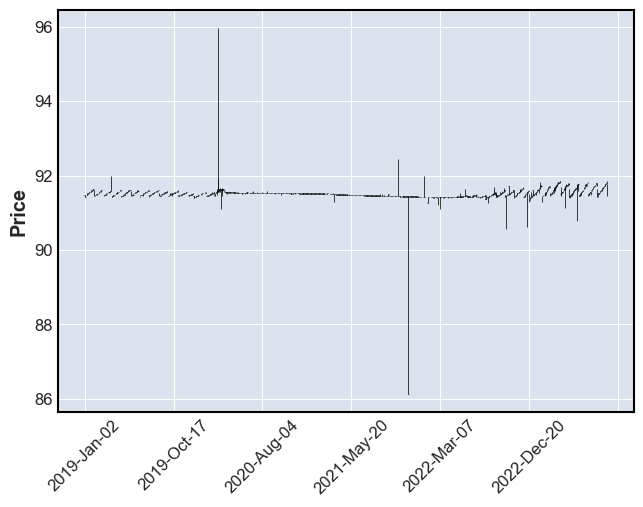

In [58]:
daily = bars.resample('1D').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
daily.dropna(inplace=True)
mpf.plot(daily, type='ohlc', show_nontrading=False, warn_too_much_data=1000000)

In [59]:
all_adjusted = div_adjust(bars, split_adjusted_dividends)

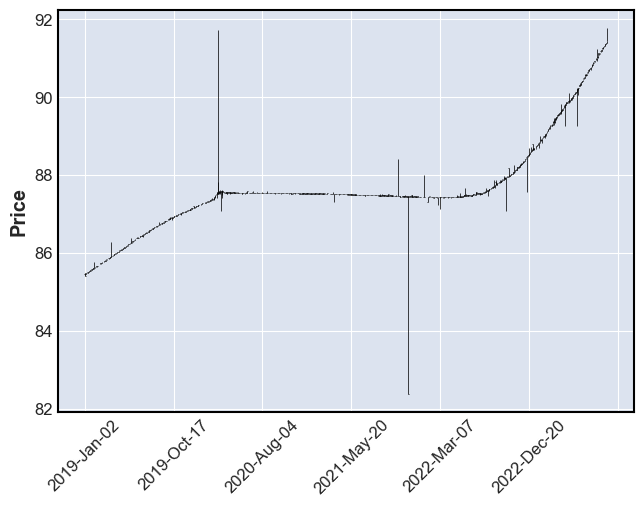

In [60]:
daily = all_adjusted.resample('1D').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
daily.dropna(inplace=True)
mpf.plot(daily, type='ohlc', show_nontrading=False, warn_too_much_data=1000000)

# Reindexing and filling in empty values

When reindexing we need to get a list of all minutes. Since we will also have to do this in the backtester (which loops over the minutes), we will store it and create a function to retrieve it.

In [61]:
market_hours = get_market_hours()

# Get all minutes from trading days
trading_datetimes = pd.date_range(start=market_hours.index[0], end=market_hours.index[-1], freq='min', name='datetime')

# Get early closes
early_closes = market_hours[market_hours['postmarket_close'] != time(19, 59)]

# Filter to all trading minutes in trading days
trading_datetimes = trading_datetimes[(trading_datetimes.time >= time(4)) & (trading_datetimes.time <= time(19, 59))] 

# Remove the minutes in early closes
for date_, early_close in early_closes.iterrows():
    postmarket_close = early_close['postmarket_close']
    trading_datetimes = trading_datetimes[~((trading_datetimes > datetime.combine(date_, early_close['postmarket_close'])) & (trading_datetimes <= datetime.combine(date_, time(19, 59)) ) )] 

trading_datetimes.to_series().to_csv(DATA_PATH + '../other/trading_minutes.csv', index=False)

In [62]:
from functools import lru_cache

# This decorator ensures that when we call a function multiple times with the same arguments, the output is stored.
# This is useful is executing the function is expensive (2-3 seconds) and gets called multiple times (for each ticker)
@lru_cache
def get_market_minutes():
    trading_datetimes = pd.read_csv(DATA_PATH + '../other/trading_minutes.csv')
    return pd.to_datetime(trading_datetimes['datetime'])

In [63]:
def reindex_and_fill(bars):
    # Get the days the ticker is trading
    ticker_days = np.unique(bars.index.date)
    market_datetimes = get_market_minutes()
    ticker_datetimes = market_datetimes[(market_datetimes.dt.date >= ticker_days[0]) & (market_datetimes.dt.date <= ticker_days[-1])]

    # Reindex
    bars = bars.reindex(ticker_datetimes)

    # Fill NA values
    bars['tradeable'] = ~bars['volume'].isna()
    bars['volume'] = bars['volume'].fillna(value=0) 

    bars["close"] = bars["close"].fillna(method="ffill")
    bars["open"] = bars["open"].fillna(bars["close"])
    bars["low"] = bars["low"].fillna(bars["close"])
    bars["high"] = bars["high"].fillna(bars["close"])

    # Only affects the very start. Else backfill shouldn't be used because of look-ahead bias.
    bars["open"] = bars["open"].fillna(method="bfill")
    bars["close"] = bars["close"].fillna(bars["open"])
    bars["low"] = bars["low"].fillna(bars["open"])
    bars["high"] = bars["high"].fillna(bars["open"])
    
    return bars

In [64]:
bars = pd.read_parquet(f"{DATA_PATH}raw/m1/BIL-2019-01-01.parquet")
bars = reindex_and_fill(bars)

In [66]:
bars.tail(3)

,open,high,low,close,volume,tradeable
datetime,,,,,,
2023-08-31 19:57:00,91.83,91.83,91.83,91.83,0.0,False
2023-08-31 19:58:00,91.83,91.83,91.83,91.83,0.0,False
2023-08-31 19:59:00,91.83,91.83,91.83,91.83,5098.0,True


# Putting it all in a loop
This takes quite some time to run. I have already tried to speed it up. It now already runs 2x faster than the original code due to the implementation of the <code>get_market_minutes()</code> function.

In [ ]:
all_files = os.listdir(f'{DATA_PATH}raw/m1/')
for index, file in enumerate(all_files):
    ticker = file[:-19] # Remove date and parquet extension

    bars = pd.read_parquet(f"{DATA_PATH}raw/m1/{file}")
    
    # CLEANING
    # I do not have tick data yet. However this is how you would do it if you got a csv of the cleaned bars only.
    # if os.path.isfile(DATA_PATH + f"raw/cleaned/{ticker}.csv"):
    #     clean_bars = pd.read_csv(DATA_PATH + f"raw/cleaned/{ticker}.csv", parse_dates=True, index_col=0)
    #     bars.update(clean_bars)

    # ADJUSTING
    split_adjusted_bars, split_adjusted_dividends = split_adjust(bars, ticker)
    all_adjusted = div_adjust(split_adjusted_bars, split_adjusted_dividends)

    # FORWARD FILLING
    all_adjusted = reindex_and_fill(all_adjusted)
    
    # HALT DETECTION
    # TO BE IMPLEMENTED
    
    all_adjusted.to_parquet(DATA_PATH + f"processed/m1/{file}", engine="pyarrow")
    
    print(ticker)


# Updating the ticker list
Now that we have the data, we can add two columns <code>start_date_data</code> and <code>end_date_data</code>.

In [ ]:
# Create 2 empty columns
# Loop through tickers
# Get first and last row of parquet file